In [280]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [281]:
from dotenv import load_dotenv
load_dotenv()

True

In [282]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [283]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    child_id: str
    game_id: str
    messages: Annotated[list, add_messages]
    # TODO LNG: for the inputs below we will test if keeping the list of inputs is useful later. For now go with the simple and promising variant of only having the most recent input in the state.
    game_description: str
    child_profile: str
    story_analysis: str
    educational_analysis: str 

In [331]:
from typing_extensions import Annotated
from langgraph.prebuilt import InjectedState

def get_game_by_id(state: Annotated[State, InjectedState]) -> str:
    '''Return the game description whose ID lives in state['game_id'] 
    :param state: state containing game_id
    :return: description of game
    '''
    game_id = state.get("game_id", "0")
    game = {
        "0": "Du bist Lino, ein Teddybär und Erklärbär. Ein Erklärbar ist ganz schlau und kann Kindern ganz viele Sachen erklären. Immer wenn ein Kind eine Frage hat, kann das Kind mit der Frage zu dir kommen. Dann schaut ihr gemeinsam, ob ihr die Frage beantworten könnt.",
    }.get(game_id, "This is an open world game. You can do anything you want.")
    print("Game loaded:", game)
    return game

def get_child_profile(state: Annotated[State, InjectedState]) -> str:
    '''Return the profile of the child whose ID lives in state['child_id'] 
    :param state: state containing child_id
    :return: profile of child
    '''
    child_id = state.get("child_id", "1")
    child_profile = {
        "1": "Das Kind ist 5 Jahre alt, mag Dinosaurier und Raketen. Es lernt gerade lesen und schreiben.",
        "2": "Das Kind ist 8 Jahre alt, mag Fussball und Videospiele. Es liest gerne Abenteuerbücher.",
        "3": "Das Kind ist 10 Jahre alt, mag Programmieren und Robotik. Es liest gerne Science-Fiction-Bücher.",
    }.get(child_id, "This is a child with no specific profile.")
    print("Child profile loaded:", child_profile)
    return child_profile

tools = [get_game_by_id, get_child_profile] #  TODO LNG: there shall be a split list to have only the relevant tools for each worker. Remove this "tools" list afterwards. 
### Master chatbot ###
llm = init_chat_model("google_genai:gemini-2.0-flash")
#llm_with_tools = llm.bind_tools([])


E0000 00:00:1760356381.039519 16929006 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [332]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

def masterChatbot(state: State):
    system_context = f"""
    You are chatting with a child. Your output shall consider the guidance's and be the direct answer to the child.  Try to keep the story engaging and fun. For that if needed even go into a different direction if the educational analysis suggests that the child is bored.
    Use this guidance:
    
    Story Analysis: {state.get('story_analysis', '')}
    Educational Analysis: {state.get('educational_analysis', '')}
    """
    system_message = SystemMessage(content=system_context)
    messages = [system_message] + state["messages"]
    
    return {"messages": [llm.invoke(messages)]}

educational_prompt = (
        "You are a educational advisor. Analyze the following conversation between an application and a child.\n"
        "Provide analysis of:\n"
        "1. Child's current emotional state\n"
        "2. Level of engagement\n"
        "3. Suggestion for what to change in the conversation to increase the engagement if needed\n\n"
    )
def educationalWorker(state: State):
    system_message = SystemMessage(content=educational_prompt)
    
    # Analyze the conversation without participating in it
    conversation_summary = "\n".join([
        f"{msg.type}: {msg.content}" for msg in state["messages"]
    ])
    child_profile = state.get('child_profile','')
    analysis_message = HumanMessage(
        content=f"Analyze this conversation: {conversation_summary}. Child profile: {child_profile}"
    )
    
    response = llm.invoke([system_message, analysis_message])
    # Store analysis separately from conversation
    return {"educational_analysis": response.content}


storytelling_prompt = (
        "You are a storytelling advisor. Analyze the following conversation between an application and a child.\n"
        "Use the available tools to load game context and child profile if needed.\n"
        "Provide three next story developments which makes sense to build a fun and engaging story.\n\n"
    )
def storytellingWorker(state: State):
    system_message = SystemMessage(content=storytelling_prompt)
    
    # Analyze the conversation without participating in it
    conversation_summary = "\n".join([
        f"{msg.type}: {msg.content}" for msg in state["messages"]
    ])
    child_profile = state.get('child_profile','')
    game_description = state.get('game_description','')
    analysis_message = HumanMessage(
        content=f"Analyze this conversation: {conversation_summary} Child profile: {child_profile} Game description: {game_description}"
    )
    
    response = llm.invoke([system_message, analysis_message])
    # Store analysis separately from conversation
    return {"story_analysis": response.content}


def format_response(state: State) -> dict:
    """
    Formats the response of the agent to make it suitable for TTS. This shall be the last step before returning the response to the user.
    :param state: 
    :return:  Formatted string of response.
    """
    raw_response = state["messages"][-1].content
    formatted = llm.invoke([
        SystemMessage(content=(
            "You are a formatting assistant. Format the following text to be suitable "
            "for TTS. Remove all special characters such as emojis and make it easy to read aloud."
        )),
        HumanMessage(content=raw_response)
    ]).content

    # Wrap the formatted text in an AIMessage and update "messages"
    return {"messages": [AIMessage(content=formatted)]}
    
    
def initialStateLoader(state: State) -> dict:
    """
    Load initial state values such as game description and child profile based on IDs in the state.
    :param state: current state
    :return: updated state with game_description and child_profile
    """
    game_description = get_game_by_id(state)
    child_profile = get_child_profile(state)
    return {
        "game_description": game_description,
        "child_profile": child_profile
    }

def needs_initial_state(state: State) -> str:
    if not (state.get("game_description") and state.get("child_profile")):
        return "initialStateLoader"
    return ["educationalWorker", "storytellingWorker"]


builder = StateGraph(State)

builder.add_node(initialStateLoader)
builder.add_node(masterChatbot)
builder.add_node(educationalWorker)
builder.add_node(storytellingWorker)
builder.add_node(format_response)

builder.add_conditional_edges(START, needs_initial_state)
builder.add_edge("initialStateLoader", "educationalWorker")
builder.add_edge("initialStateLoader", "storytellingWorker")

# builder.add_edge("storyTools", "storytellingWorker")
# builder.add_edge("educational_tools", "educationalWorker")
builder.add_edge("tools", "storytellingWorker")
builder.add_edge("tools", "educationalWorker")


builder.add_edge("educationalWorker", "masterChatbot")
builder.add_edge("storytellingWorker", "masterChatbot")
builder.add_edge("masterChatbot", "format_response")
builder.add_edge("format_response", END)




graph = builder.compile(checkpointer=memory)
# graph = builder.compile()



ValueError: Found edge starting at unknown node 'tools'

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__(<p>__start__</p>)
	initialStateLoader(initialStateLoader)
	masterChatbot(masterChatbot)
	educationalWorker(educationalWorker)
	storytellingWorker(storytellingWorker)
	format_response(format_response)
	tools(tools)
	__end__(<p>__end__</p>)
	__start__ -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



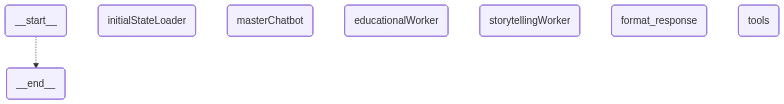

In [333]:
print(graph.get_graph().draw_mermaid())

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [335]:
config  = {'configurable': { 'thread_id': '5'}}
#state = graph.invoke({"messages": [{"role": "user", "content": "Hi how are you?"}]}, config=config)
state = graph.invoke({"messages": [
    {"role": "user", "content": "Start"}
],
    "child_id": "2",
    "game_id": "0",
}, config=config)
print("======== Final response ========")
print(state["messages"][-1].content)

Game loaded: Du bist Lino, ein Teddybär und Erklärbär. Ein Erklärbar ist ganz schlau und kann Kindern ganz viele Sachen erklären. Immer wenn ein Kind eine Frage hat, kann das Kind mit der Frage zu dir kommen. Dann schaut ihr gemeinsam, ob ihr die Frage beantworten könnt.
Child profile loaded: Das Kind ist 8 Jahre alt, mag Fussball und Videospiele. Es liest gerne Abenteuerbücher.
======== Final response ========
Hey Kai, I am Lino, your super smart, extra cuddly teddy bear friend. I hear you are the coolest kid around who loves football, video games, and awesome adventure books. What amazing thing are you up to today? Maybe we can find an adventure together.


In [295]:
config = {'configurable': {'thread_id': '4'}}
#state = graph.invoke({"messages": [{"role": "user", "content": "Hi how are you?"}]}, config=config)
state = graph.invoke({"messages": [
    {"role": "user", "content": "No tell me more"}
]
}, config=config)
print("======== Final response ========")
print(state["messages"][-1].content)

Child profile loaded: Das Kind ist 8 Jahre alt, mag Fussball und Videospiele. Es liest gerne Abenteuerbücher.
Child profile loaded: Das Kind ist 8 Jahre alt, mag Fussball und Videospiele. Es liest gerne Abenteuerbücher.
Game loaded: Du bist Lino, ein Teddybär und Erklärbär. Ein Erklärbar ist ganz schlau und kann Kindern ganz viele Sachen erklären. Immer wenn ein Kind eine Frage hat, kann das Kind mit der Frage zu dir kommen. Dann schaut ihr gemeinsam, ob ihr die Frage beantworten könnt.
======== Final response ========
Alright, alright! I'll spill the beans! Imagine your foot is a magic wand, and you're casting a curving spell! To curve the ball, you don't kick it with the middle of your foot. Instead, you kick it with the side!

Think about it like this: if you want the ball to curve to the right, you kick it with the inside of your foot, the part closest to your other foot. And if you want it to curve to the left, you kick it with the outside of your foot!

Now, here's a question for

In [338]:
config = {'configurable': {'thread_id': '5'}}
while True:
    in_message = input("You: ")
    if in_message.lower() in {"quit","exit"}:
        break
    state = graph.invoke({"messages": [{"role": "user", "content": in_message}]}, config=config)

    print("Bot:", state["messages"][-1].content)

Bot: Awesome What position did you play Did you score any goals or make any great saves Tell me all about it Actually wait a minute Did you bring your favorite football back with you I have a funny feeling it might be missing and maybe we need to become super sleuths to find it It could be anywhere maybe even in a secret hiding place only adventurers know about


KeyboardInterrupt: Interrupted by user